# Eigenspace ActFlow -- Compute the baseline decodability of Motor responses (LINDEX v. LMID and RINDEX v. RMID)
## Using ActFlow, All to one, but in the eigenspace

## Use SVM classifications to decode hand-specific responses
## Using Ciric-style postprocessing

## Takuya Ito
#### 02/16/2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
import nibabel as nib
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import sklearn.svm as svm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
from sklearn.feature_selection import f_classif
import seaborn as sns
import h5py
os.sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import statsmodels.api as sm

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


/home/tito/miniconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



basedir = '/projects3/SRActFlow/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# 0.0 Define functions for loading data

In [52]:
def loadMotorResponses(subj,hand='Right'):
    
    hands = {'Left':[0,1],'Right':[2,3]}

    x = tgp.loadTaskTiming(subj,'ALL')
    stimIndex = np.asarray(x['stimIndex'])
    ind = np.where(stimIndex=='motorResponse')[0]
    
    datadir = basedir + 'data/postProcessing/hcpPostProcCiric/'
    h5f = h5py.File(datadir + subj + '_glmOutput_data.h5','r')
    data = h5f['taskRegression/ALL_24pXaCompCorXVolterra_taskReg_betas_canonical'][:].copy()
    data = data[:,ind].copy()
    h5f.close()
    
    # Isolate hand responses
    hand_ind = hands[hand]
    tmpdat = np.zeros((data.shape[0],2))
    if hand=='Right':
        tmpdat[:,0] = data[:,3]
        tmpdat[:,1] = data[:,2]
    elif hand=='Left':
        tmpdat[:,0] = data[:,0]
        tmpdat[:,1] = data[:,1]
    data = tmpdat.copy()
    
    return data

def loadFCandEig(subj,roi):
    fcdir = '/projects3/SRActFlow/data/results/pcaFC_inEigenspace/'
#     filename = fcdir + 'TargetParcel' + str(roi) + '_RidgeFC.h5'
    filename = fcdir + 'TargetParcel' + str(roi) + '_pcaFC_nozscore.h5'
    h5f = h5py.File(filename,'r')
    fcmapping = h5f[subj]['sourceToTargetMapping'][:].copy()
    eigenvectors = h5f[subj]['eigenvectors'][:].copy()
    h5f.close()
    
    
    ## Remove collider coefficients
#     tmp = np.corrcoef(eigenvectors)
#     colliders = []
#     count = 0
#     for i in range(eigenvectors.shape[0]):
#         for j in range(eigenvectors.shape[0]):
#             if i==j: continue
#             if i<j: 
#                 # If it is potentially a collider variable, set the coefficient to 0
#                 if np.abs(tmp[i,j]) > 0.1:
#                     fcmapping[j,:] = 0
#                     colliders.append(j)
#                     count += 1
                    
#     print colliders
#     print float(count)/fcmapping.shape[0]
    return fcmapping, eigenvectors


## Load masks
def loadMask(roi,dilated=True):
    maskdir = basedir + 'data/results/surfaceMasks/'
    if dilated:
        maskfile = maskdir + 'GlasserParcel' + str(roi) + '_dilated_10mm.dscalar.nii'
    else:
        maskfile = maskdir + 'GlasserParcel' + str(roi) + '.dscalar.nii'
    maskdata = np.squeeze(nib.load(maskfile).get_data())
    
    return maskdata
        

# 1.0 Define functions for motor response decodings

In [204]:
from scipy.spatial.distance import cdist

def motorResponseDecodings(data, actflow_data, rois, ncvs=1, nproc=5):
    """
    Run an across-subject classification
    Decode responses on each hand separately from CPRO data
    """

    nSubjs = data.shape[2]
    stats = np.zeros((len(rois),))
    
    nfing = data.shape[1]

    nsamples = nSubjs * nfing

    # Label array for supervised learning
    labels = np.tile(range(nfing),nSubjs)
    subjarray = np.repeat(range(nSubjs),nfing)

    # Run SVM classifications on network-level activation patterns across subjects
    roicount = 0
    for roi in rois:
        roi_ind = np.where(glasser2==roi)[0]
        nfeatures = len(roi_ind)
        roi_ind.shape = (len(roi_ind),1)       

        svm_mat = np.zeros((nsamples,roi_ind.shape[0]))
        actflow_svm_mat = np.zeros((nsamples,roi_ind.shape[0]))
        samplecount = 0
        scount = 0
        for subj in range(len(subjNums)):
            roidata = np.squeeze(data[roi_ind,:,scount])
            actflow_roidata = np.squeeze(actflow_data[roi_ind,:,scount])
            svm_mat[samplecount:(samplecount+nfing),:] = roidata.T
            actflow_svm_mat[samplecount:(samplecount+nfing),:] = actflow_roidata.T

            scount += 1
            samplecount += nfing

            # Spatially demean matrix across features
            samplemean = np.mean(svm_mat,axis=1)
            samplemean.shape = (len(samplemean),1)
            svm_mat = svm_mat - samplemean
            
            samplemean = np.mean(actflow_svm_mat,axis=1)
            samplemean.shape = (len(samplemean),1)
            actflow_svm_mat = actflow_svm_mat - samplemean

        scores = randomSplitLOOBaselineCV(ncvs, svm_mat, actflow_svm_mat, labels, subjarray, nproc=nproc)
        stats[roicount] = np.mean(scores)
        roicount += 1
        
    return stats

def randomSplitLOOBaselineCV(ncvs, svm_mat, actflow_svm_mat, labels, subjarray, nproc=5):
    """
    Runs cross validation for an across-subject SVM analysis
    """
    
    ntasks = len(np.unique(labels))
    nsamples = svm_mat.shape[0]
    nsubjs = nsamples/ntasks

    subjects = np.unique(subjarray)
    indices = np.arange(nsamples)
    
    numsubjs_perfold = 1
    if nsubjs%numsubjs_perfold!=0: 
        raise Exception("Error: Folds don't match number of subjects")
        
    nfolds = nsubjs/numsubjs_perfold
    subj_array_folds = subjarray.copy()
    
    inputs = [] 
    
    for fold in range(nfolds):
        test_subjs = np.random.choice(subj_array_folds,numsubjs_perfold,replace=False)
        train_subjs_all = np.delete(subjects,test_subjs)
        for cv in range(ncvs):
            # Randomly sample half of train set subjects for each cv (CV bootstrapping)
            train_subjs = np.random.choice(train_subjs_all,
                                         int(np.floor(len(train_subjs_all)*(4.0))),
                                         replace=True)

            train_ind = []
            for subj in train_subjs:
                train_ind.extend(np.where(subjarray==subj)[0])

            test_ind = []
            for subj in test_subjs:
                test_ind.extend(np.where(subjarray==subj)[0])
            
            train_ind = np.asarray(train_ind)
            test_ind = np.asarray(test_ind)

            trainset = actflow_svm_mat[train_ind,:]
            testset = svm_mat[test_ind,:]
            orig_training = svm_mat[train_ind,:]

            # Normalize trainset and testset
            trainmean = np.mean(actflow_svm_mat[train_ind,:],axis=0)
            trainmean.shape = (1,len(trainmean))
            trainstd = np.std(actflow_svm_mat[train_ind,:],axis=0)
            trainstd.shape = (1,len(trainstd))
            
            # Normalize trainset and testset
            testmean = np.mean(svm_mat[train_ind,:],axis=0)
            testmean.shape = (1,len(testmean))
            teststd = np.std(svm_mat[train_ind,:],axis=0)
            teststd.shape = (1,len(teststd))

            trainset = np.divide((trainset - trainmean),trainstd)
            testset = np.divide((testset - testmean),teststd)

            ######## FEATURE SELECTION & REDUCTION
            ## Feature selection and downsampling
#             trainlabels = labels[train_ind]
#             testlabels = labels[test_ind]
#             unique_labels = np.unique(labels)
#             feat1_labs = np.where(trainlabels==0)[0]
#             feat2_labs = np.where(trainlabels==1)[0]
#             # Perform t-test
#             t, p = stats.ttest_rel(orig_training[feat1_labs,:],orig_training[feat2_labs,:],axis=0)
#             h0, qs = mc.fdrcorrection0(p)
#             # Construct feature masks
#             feat1_mask = np.multiply(t<0,h0)
#             feat2_mask = np.multiply(t>0,h0)
# #             feat1_mask = t>0
# #             feat2_mask = t<0
#             # Downsample training set into original vertices into 2 ROI signals
#             trainset_downsampled = np.zeros((trainset.shape[0],2))
#             trainset_downsampled[:,0] = np.nanmean(trainset[:,feat1_mask],axis=1)
#             trainset_downsampled[:,1] = np.nanmean(trainset[:,feat2_mask],axis=1)
#             trainset_downsampled = trainset[:,h0]
#             # Downsample test set into original vertices
#             testset_downsampled = np.zeros((testset.shape[0],2))
#             testset_downsampled[:,0] = np.nanmean(testset[:,feat1_mask],axis=1)
#             testset_downsampled[:,1] = np.nanmean(testset[:,feat2_mask],axis=1)
#             testset_downsampled = testset[:,h0]
# #             print 'feat1_mask', np.sum(feat1_mask), '| feat2_mask', np.sum(feat2_mask)

#             if np.sum(feat1_mask)==0 or np.sum(feat2_mask)==0:
#                 print 'not running feature selection'
#                 inputs.append((trainset,testset,labels[train_ind],labels[test_ind]))
#             else:
#                 inputs.append((trainset_downsampled,testset_downsampled,labels[train_ind],labels[test_ind]))

            inputs.append((trainset,testset,labels[train_ind],labels[test_ind]))         
    
        subj_array_folds = np.delete(subj_array_folds,test_subjs)
        
    pool = mp.Pool(processes=nproc)
    scores = pool.map_async(_decoding,inputs).get()
    pool.close()
    pool.join()

    acc = []
    for score in scores:
        acc.extend(score)
    return acc

def _decoding((trainset,testset,trainlabels,testlabels)):

#     clf = sklearn.linear_model.LogisticRegression()
#     clf = svm.SVC(C=1.0, kernel='linear')

#     clf.fit(trainset,trainlabels)
#     predictions = clf.predict(testset)
#     acc = predictions==testlabels
    
    unique_cond = np.unique(trainlabels)
    acc = []
    for cond1 in unique_cond:
        mismatches = []
        prototype_ind = np.where(trainlabels==cond1)[0]
        prototype = np.mean(trainset[prototype_ind,:],axis=0)
        for cond2 in unique_cond:
            test_ind = np.where(testlabels==cond2)[0]
            test = np.mean(testset[test_ind,:],axis=0)
            if cond1 == cond2: 
                correct = stats.spearmanr(prototype,test)[0]
            else:
                mismatches.append(stats.spearmanr(prototype,test)[0])
#         print correct, mismatches
        if correct > np.max(mismatches): 
            acc.append(1.0)
        else:
            acc.append(0.0)
    
    return acc

## 1.01 Load data for both hand responses

In [107]:
# gsr = True
nResponses = 2
data_task_rh = np.zeros((len(glasser2),nResponses,len(subjNums)))
data_task_lh = np.zeros((len(glasser2),nResponses,len(subjNums)))

scount = 0
for subj in subjNums:
    data_task_rh[:,:,scount] = loadMotorResponses(subj,hand='Right')
    data_task_lh[:,:,scount] = loadMotorResponses(subj,hand='Left')
    scount += 1

## 2.0 Perform actflow and decode ROIs for RH responses

In [205]:
n_components_include = 400

Running 20
Running 40
Running 60
Running 80
Running 100
Running 120
Running 140
Running 160
Running 180
Running 200
Running 220
Running 240
Running 260
Running 280
Running 300
Running 320
Running 340
Running 360
Running 380
Running 400
Running 420
Running 440
Running 460
Running 480


NameError: name 'ncomponents_sweepdecoding_accuracy_rh' is not defined

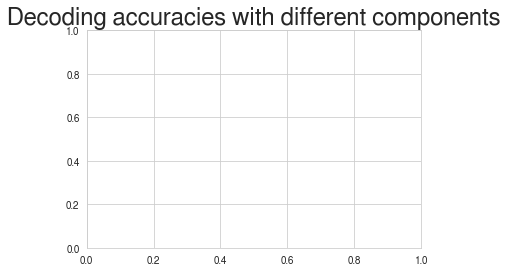

In [223]:
roi_rh = 9
roi_lh = 189

predicted_to_actual_similarity_rh1 = []
predicted_to_actual_similarity_rh2 = []
decoding_accuracy_rh = []
decoding_pvalue_rh = []
ncomponents_sweep = np.arange(2,500)

for n_components_include in ncomponents_sweep:
    actflow_data_rh = np.zeros((len(glasser2),nResponses,len(subjNums)))
    if n_components_include % 20 == 0: print 'Running', n_components_include

    dilateLH = loadMask(roi_lh,dilated=True)
    dilateRH = loadMask(roi_rh,dilated=True)
    combinedDilated = dilateLH + dilateRH
    # combinedDilated = dilateRH
    # Exclude all SMN regions
    smn_rois = np.where(networkdef==networkmappings['smn'])[0]
    for x in smn_rois:
        roi_ind = np.where(glasser2==x)[0]
        combinedDilated[roi_ind]=1
    source_ind = np.where(combinedDilated==0)[0]
    scount = 0
    for subj in subjNums:
    #     print 'Subject', subj, '(', scount+1, '/', len(subjNums), ')'
        target_ind = np.where(glasser2==roi_rh)[0]

        fcmapping_rh, eigenvector = loadFCandEig(subj,roi_rh)
    #     tmp = np.multiply(fcmapping_rh>0,fcmapping_rh)

        # Map activity to eigenspace
    #     eigen_activity1 = np.dot(stats.zscore(data_task_rh[source_ind,0,scount],axis=0),eigenvector[:n_components_include,:].T)
    #     eigen_activity2 = np.dot(stats.zscore(data_task_rh[source_ind,1,scount],axis=0),eigenvector[:n_components_include,:].T)
        eigen_activity1 = np.dot(data_task_rh[source_ind,0,scount],eigenvector[:n_components_include,:].T)
        eigen_activity2 = np.dot(data_task_rh[source_ind,1,scount],eigenvector[:n_components_include,:].T)

        # Right Finger 1
        actflow_data_rh[target_ind,0,scount] = np.dot(eigen_activity1,fcmapping_rh[:n_components_include,:])
        # Right Finger 2:
        actflow_data_rh[target_ind,1,scount] = np.dot(eigen_activity2,fcmapping_rh[:n_components_include,:])

        scount += 1

    ###################################
    ## Run decoding    
    nproc = 20
    ncvs = 1

    rois = np.where(networkdef==networkmappings['smn'])[0] + 1
    rois = [roi_rh] # Left S1

    # distances_baseline_rh = motorResponseDecodings(stats.zscore(data_task_rh,axis=0), 
    #                                                actflow_data_rh,
    #                                                rois, ncvs=ncvs, nproc=nproc)
    distances_baseline_rh = motorResponseDecodings(data_task_rh, 
                                                   actflow_data_rh,
                                                   rois, ncvs=ncvs, nproc=nproc)

    ###################################
    ## Compute statistics
    statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
    ntrials = len(subjNums)*2
    p = stats.binom_test(distances_baseline_rh[0]*ntrials,n=ntrials,p=0.5)
    if np.mean(distances_baseline_rh[0])>0.5:
        p = p/2.0
    else:
        p = 1.0-p/2.0

    statistics_rh[0,0] = np.mean(distances_baseline_rh[0])
    statistics_rh[0,1] = p

    decoding_accuracy_rh.append(statistics_rh[0,0])
    decoding_pvalue_rh.append(p)


#     print 'Accuracy:', statistics_rh[0,0]
#     print 'P-value:', statistics_rh[0,1]

    predicted_to_actual_rh1, p1 = stats.spearmanr(np.mean(data_task_rh[roi_ind_rh,0,:],axis=1),np.mean(actflow_data_rh[roi_ind_rh,0,:],axis=1))
    predicted_to_actual_rh2, p2 = stats.spearmanr(np.mean(data_task_rh[roi_ind_rh,1,:],axis=1),np.mean(actflow_data_rh[roi_ind_rh,1,:],axis=1))
    
    predicted_to_actual_similarity_rh1.append(predicted_to_actual_rh1)
    predicted_to_actual_similarity_rh2.append(predicted_to_actual_rh2)

#     print predicted_to_actual_lh1, p3
#     print predicted_to_actual_lh2, p4


plt.figure()
plt.title('Decoding accuracies with different components',fontsize=24)
plt.plot(ncomponents_sweep,decoding_accuracy_rh)
plt.ylabel('Decoding accuracy',fontsize=20)
plt.xlabel('Number of components',fontsize=20)

plt.figure()
plt.title('Predicted to actual similarity with different components',fontsize=24)
plt.plot(predicted_to_actual_similarity_rh1,label='RH1')
plt.plot(predicted_to_actual_similarity_rh2,label='RH2')
plt.ylabel('Spatial similarity',fontsize=20)
plt.xlabel('Number of components',fontsize=20)
plt.legend()

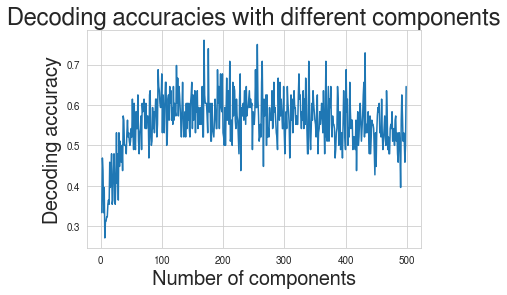

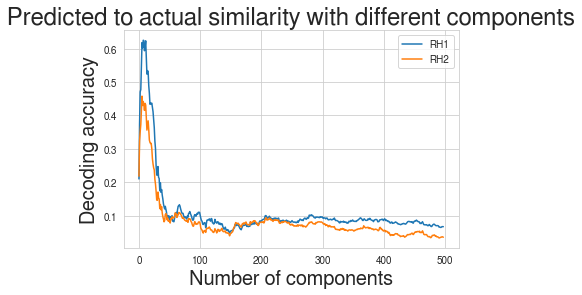

In [224]:
plt.figure()
plt.title('Decoding accuracies with different components',fontsize=24)
plt.plot(ncomponents_sweep,decoding_accuracy_rh,)
plt.ylabel('Decoding accuracy',fontsize=20)
plt.xlabel('Number of components',fontsize=20)

plt.figure()
plt.title('Predicted to actual similarity with different components',fontsize=24)
plt.plot(predicted_to_actual_similarity_rh1,label='RH1')
plt.plot(predicted_to_actual_similarity_rh2,label='RH2')
plt.ylabel('Spatial similarity',fontsize=20)
plt.xlabel('Number of components',fontsize=20)
plt.legend()

## 2.0 Perform actflow and decode ROIs for LH responses

Running 20
Running 40
Running 60
Running 80
Running 100
Running 120
Running 140
Running 160
Running 180
Running 200
Running 220
Running 240
Running 260
Running 280
Running 300
Running 320
Running 340
Running 360
Running 380
Running 400
Running 420
Running 440
Running 460
Running 480


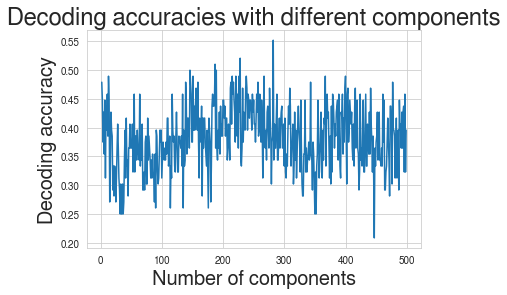

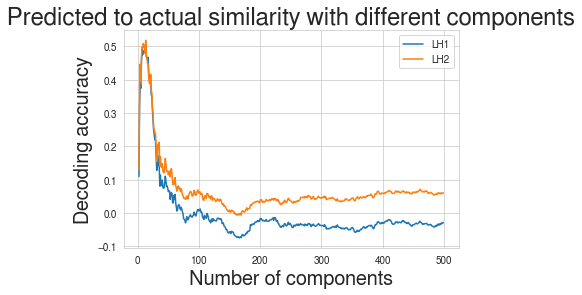

In [225]:
roi_rh = 9
roi_lh = 189

predicted_to_actual_similarity_lh1 = []
predicted_to_actual_similarity_lh2 = []
decoding_accuracy_lh = []
decoding_pvalue_lh = []
ncomponents_sweep = np.arange(2,500)

for n_components_include in ncomponents_sweep:
    actflow_data_lh = np.zeros((len(glasser2),nResponses,len(subjNums)))
    if n_components_include % 20 == 0: print 'Running', n_components_include

    dilateLH = loadMask(roi_lh,dilated=True)
    dilateRH = loadMask(roi_rh,dilated=True)
    combinedDilated = dilateLH + dilateRH
    # combinedDilated = dilateLH
    # Exclude all SMN regions
    smn_rois = np.where(networkdef==networkmappings['smn'])[0]
    for x in smn_rois:
        roi_ind = np.where(glasser2==x)[0]
        combinedDilated[roi_ind]=1
    source_ind = np.where(combinedDilated==0)[0]
    scount = 0
    for subj in subjNums:
    #     print 'Subject', subj, '(', scount+1, '/', len(subjNums), ')'
        target_ind = np.where(glasser2==roi_lh)[0]

        fcmapping_lh,eigenvector = loadFCandEig(subj,roi_lh)
    #     tmp = np.multiply(fcmapping_lh>0,fcmapping_lh)

        # Map activity to eigenspace
    #     eigen_activity1 = np.dot(stats.zscore(data_task_lh[source_ind,0,scount],axis=0),eigenvector[:n_components_include,:].T)
    #     eigen_activity2 = np.dot(stats.zscore(data_task_lh[source_ind,1,scount],axis=0),eigenvector[:n_components_include,:].T)
        eigen_activity1 = np.dot(data_task_lh[source_ind,0,scount],eigenvector[:n_components_include,:].T)
        eigen_activity2 = np.dot(data_task_lh[source_ind,1,scount],eigenvector[:n_components_include,:].T)

        # Right Finger 1
        actflow_data_lh[target_ind,0,scount] = np.dot(eigen_activity1,fcmapping_lh[:n_components_include,:])
        # Right Fingel 2:
        actflow_data_lh[target_ind,1,scount] = np.dot(eigen_activity2,fcmapping_lh[:n_components_include,:])

        scount += 1


    ##################
    ## Run decoding
    ncvs = 1

    rois = np.where(networkdef==networkmappings['smn'])[0] + 1
    rois = [roi_lh] # Left S1

    # distances_baseline_lh = motorResponseDecodings(stats.zscore(data_task_lh,axis=0), 
    #                                                actflow_data_lh,
    #                                                rois, ncvs=ncvs, nproc=nproc)
    distances_baseline_lh = motorResponseDecodings(data_task_lh, 
                                                   actflow_data_lh,
                                                   rois, ncvs=ncvs, nproc=nproc)

    ##################
    ## Compute statistics
    statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
    ntrials = len(subjNums)*2
    p = stats.binom_test(distances_baseline_lh[0]*ntrials,n=ntrials,p=0.5)
    if np.mean(distances_baseline_lh[0])>0.5:
        p = p/2.0
    else:
        p = 1.0-p/2.0

    statistics_lh[0,0] = np.mean(distances_baseline_lh[0])
    statistics_lh[0,1] = p

    decoding_accuracy_lh.append(statistics_lh[0,0])
    decoding_pvalue_lh.append(statistics_lh[0,1])


#     print 'Accuracy:', statistics_lh[0,0]
#     print 'P-value:', statistics_lh[0,1]

    ## Calculate predicted to actual similarities
    predicted_to_actual_lh1, p3 = stats.spearmanr(np.mean(data_task_lh[roi_ind_lh,0,:],axis=1),np.mean(actflow_data_lh[roi_ind_lh,0,:],axis=1))
    predicted_to_actual_lh2, p4 = stats.spearmanr(np.mean(data_task_lh[roi_ind_lh,1,:],axis=1),np.mean(actflow_data_lh[roi_ind_lh,1,:],axis=1))
    
    predicted_to_actual_similarity_lh1.append(predicted_to_actual_lh1)
    predicted_to_actual_similarity_lh2.append(predicted_to_actual_lh2)

#     print predicted_to_actual_lh1, p3
#     print predicted_to_actual_lh2, p4


plt.figure()
plt.title('Decoding accuracies with different components',fontsize=24)
plt.plot(ncomponents_sweep,decoding_accuracy_lh)
plt.ylabel('Decoding accuracy',fontsize=20)
plt.xlabel('Number of components',fontsize=20)

plt.figure()
plt.title('Predicted to actual similarity with different components',fontsize=24)
plt.plot(ncomponents_sweep,predicted_to_actual_similarity_lh1,label='LH1')
plt.plot(ncomponents_sweep,predicted_to_actual_similarity_lh2,label='LH2')
plt.ylabel('Spatial similarity',fontsize=20)
plt.xlabel('Number of components',fontsize=20)
plt.legend()